In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.style.use("../config/custom_plots.mplstyle")

```yaml
nAgents: 10000
nSteps: 1000000
nSaveSteps: 1000
nRuns: 10
networkP: 0.8
networkM: 10
additionalLinksFraction: 0.01
virtualLayer: true
epidemicLayer: true
comorbidities: false
qVoterParameters:
  p: 0.3
  q: 6
epidemicLayerParameters:
  beta: 0.9
  gamma: 0.5
  mu: 0.9
  kappa: 0.1
maxInfectedTimeMean: 10
maxInfectedTimeStd: 5
positiveOpinionFraction: 1.0
infectedFraction: 0.1
fractionIllnessA: 0.0
fractionIllnessB: 0.0
outputFolder: simulations/results_remove_links_parameters_beta_off
firstParameterRange:
  start: 0.0
  end: 1.0
  count: 51
  vals: null
  type: positiveOpinionFraction
secondParameterRange: null
linksRemoval: false
nQVoterPerStep: 1
```


In [2]:
%%time

def load_df(prefix, fracPos, beta, folder, nagents=10000, nsteps=1000000, nruns=10):
    dfs = []
    for n in range(nruns):
        path = f"../simulations/{folder}/{prefix}_NAGENTS={nagents}_NSTEPS={nsteps}_NETWORKP=0.8_FRAC_LINKS=0.01_FRAC_POS_OPINION={fracPos}_FRAC_A=0.0_FRAC_B=0.0_FRAC_INFECTED=0.1_QVOTER=p=0.30_q=6_EPIDEMIC=beta={beta}_gamma=0.50_mu=0.90_kappa=0.10_I_TIME_MEAN=10.0_I_TIME_STD=5.0_NRUN={n}.tsv"
        df = pd.read_csv(path, sep="\t")
        dfs.append(df)
    dfs1 = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).mean(axis=0),
                        index=df.index, 
                        columns=df.columns)
    return dfs1


fPs = ['{:.2f}'.format(x / 100) for x in list(range(101))[::2]]

new_fPs = []
for idx, fP in enumerate(fPs):
    if idx % 5 == 0:
        new_fPs.append('{:.1f}'.format(float(fP)))
    else:
        new_fPs.append(fP)

off_beta_low = [load_df('off', f, '0.10', 'results_remove_links_parameters_beta_off') for f in new_fPs]
on_beta_low = [load_df('on', f, '0.10', 'results_remove_links_parameters_beta_on') for f in new_fPs]

off_beta_middle = [load_df('off', f, '0.50', 'results_remove_links_parameters_beta_off') for f in new_fPs]
on_beta_middle = [load_df('on', f, '0.50', 'results_remove_links_parameters_beta_on') for f in new_fPs]

off_beta_high = [load_df('off', f, '0.90', 'results_remove_links_parameters_beta_off') for f in new_fPs]
on_beta_high = [load_df('on', f, '0.90', 'results_remove_links_parameters_beta_on') for f in new_fPs]

# Simulations without opinion layer
off_beta_low_no = [load_df('off', f, '0.10', 'results_remove_links_parameters_beta_off_no_virtual') for f in new_fPs]
on_beta_low_no = [load_df('on', f, '0.10', 'results_remove_links_parameters_beta_on_no_virtual') for f in new_fPs]

off_beta_middle_no = [load_df('off', f, '0.50', 'results_remove_links_parameters_beta_off_no_virtual') for f in new_fPs]
on_beta_middle_no = [load_df('on', f, '0.50', 'results_remove_links_parameters_beta_on_no_virtual') for f in new_fPs]

off_beta_high_no = [load_df('off', f, '0.90', 'results_remove_links_parameters_beta_off_no_virtual') for f in new_fPs]
on_beta_high_no = [load_df('off', f, '0.90', 'results_remove_links_parameters_beta_on_no_virtual') for f in new_fPs]

CPU times: user 47.1 s, sys: 987 ms, total: 48.1 s
Wall time: 49.1 s


In [3]:
def time_max_infected(dfs):
    times = []
    for df in dfs:
        t = df[df['infectedRate'] == df['infectedRate'].max()].step.to_numpy()[0]
        times.append(t)
    return np.array(times)
    
def max_by_columns(dfs, column):
    val = []
    for df in dfs:
        i = df[column].max()
        val.append(i)
    return np.array(val)

def last_by_columns(dfs, column):
    val = []
    for df in dfs:
        i = df[column].to_numpy()[-1]
        val.append(i)
    return np.array(val)


def time_to_no_susceptible(dfs):
    val = []
    for df in dfs:
        i = df[df['susceptibleRate'] < 1e-2].step.values
        if len(i) >= 1:
            val.append(i[0])
        else:
            val.append(0)
    return val

In [4]:
colors = ['red', 'blue', 'violet', 'green', 'black', 'yellow', 
          'salmon', 'peach', 'teal', 'sky blue', 'lime', 'olive']
colors = ['xkcd:' + c for c in colors]

x = [float(x) for x in new_fPs] 


def plot_all_vals(ys, fun, ylabel, betas):
    i, j = 0, 0
    for y in ys:
        plt.plot(x, fun(y[0]), label=r'with, $\beta={}$'.format(betas[j]), color=colors[i])
        plt.plot(x, fun(y[1]), label=r'without, $\beta={}$'.format(betas[j]), color=colors[i+1])
        i += 2
        j += 1
    plt.legend(loc=(1.01, 0.05))
    plt.xlabel('positive opinion fraction')
    plt.ylabel(ylabel)    

### Kiedy nastąpi pik zachorowań w funkcji początkowej opinii agentów?

Legenda:

- `with`: z włączoną funkcją usuwania linków
- `without`: z wyłączoną funkcją usuwania linków

Można zauważyć, że dla mniejszych wartości $\beta$ istnieje znaczna różnica pomiędzy opcją z i bez usuwania linków. Ta różnica uwidacznia się szczególnie dla większych wartości odsetku agentów z pozytywną opinią. Czas w którym następuje pik przesuwa się, czyli mamy korzystną (z punktu widzenia służby zdrowia) własność wypłaszczania krzywej (o piku zachorowań w następnej części). Dla większych wartości $\beta$ ten efekt jest mniej widoczny.

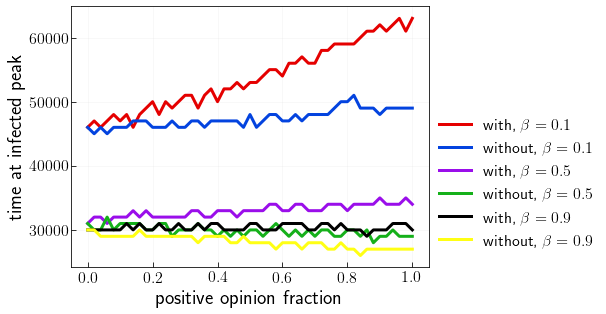

In [12]:
ys = [(on_beta_low, off_beta_low), (on_beta_middle, off_beta_middle), (on_beta_high, off_beta_high)]
betas = ['0.1', '0.5', '0.9']

plot_all_vals(ys, time_max_infected, 'time at infected peak', betas)

Dodatkowo przetestowałem, czy wogóle dynamika opinii tutaj wpływa na wyniki. Przeprowadziłem symulację, gdzie wyłączyłem warstwę komunikacyjną.

Wyniki wskazują, że ewolucja opinii wpływa na ten czas.

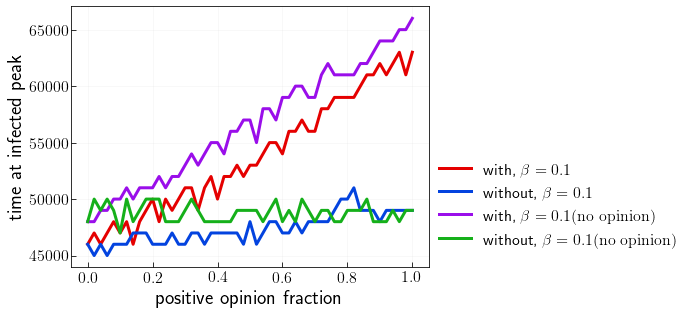

In [14]:
ys = [(on_beta_low, off_beta_low), (on_beta_low_no, off_beta_low_no)]
betas = ['0.1', r'0.1 \textrm{(no opinion)}']

plot_all_vals(ys, time_max_infected, 'time at infected peak', betas)

### Wysokość piku zachorowań w zależności od początkowej opinii

Na osi Y jest przedstawiona wartość maksymalna odsetku osób zarażonych. Warto też brać pod uwagę wyniki z poprzedniej części.

Wyniki sugerują, że mechanizm redukcji połączeń dla osób z pozytywną opinią o przestrzeganiu restrykcjach znacząco redukuje maksymalna wartość piku zarażonych, jednak istotne jest to, że duża część populacji jest tego samego nastawienia.

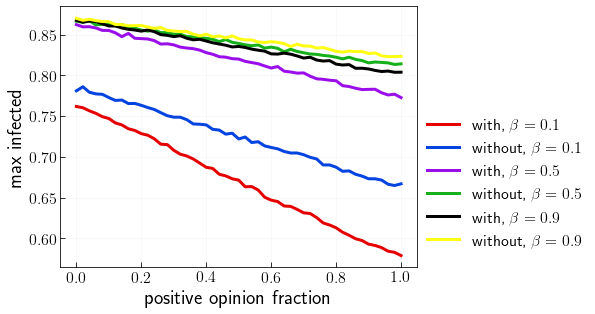

In [15]:
ys = [(on_beta_low, off_beta_low), (on_beta_middle, off_beta_middle), (on_beta_high, off_beta_high)]
betas = ['0.1', '0.5', '0.9']

plot_all_vals(ys, lambda x: max_by_columns(x, 'infectedRate'), 'max infected', betas)

Tutaj również zbadałem wpływ ewolucji opinii na analizowane przebiegi. I wykres poniżej potwierdza, że sieć z modelem q-votera pomaga w redukcji liczby zarażonych

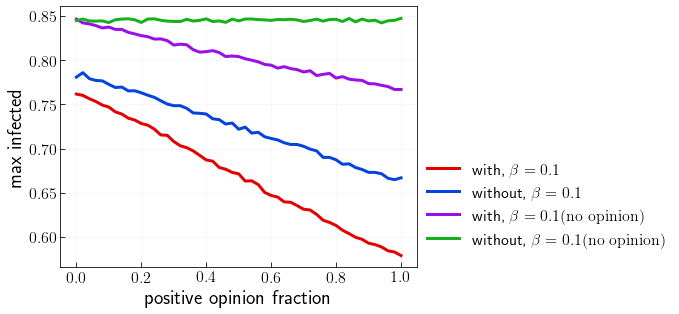

In [16]:
ys = [(on_beta_low, off_beta_low), (on_beta_low_no, off_beta_low_no)]
betas = ['0.1', r'0.1 \textrm{(no opinion)}']

plot_all_vals(ys, lambda x: max_by_columns(x, 'infectedRate'), 'max infected', betas)

Nasuwa się pytanie, jak dużo zyskujemy ograniczając swoje kontakty. Prostym sposobem jest obliczenie stosunku maksymalnego odsetku zarażonych bez usuwania linków do mechanizmu usuwania linków (może jest jeszcze inne lepsze rozwiązanie). 

Wyniki można interpretować następująco: (dla $\beta=0.1$) kiedy w społeczeństwie wszyscy są negatywnie nastawieni do przestrzegania restrykcji to mamy redukcję piku o 0.98, natomiast w idealnym społeczeństwie, kiedy wszyscy przestrzegają restrykcji ta redukcja jest rzędu 0.87. Trzeba tutaj też pamiętać, że spowalniamy również czas, kiedy ten pik nastąpi. Ten efekt jednak nie jest aż tak znaczący, kiedy dana choroba ma duże prawdopodobieństwo rozprzestrzeniania. 


Mój pomysł na rozszerzenie tego:
  
- obliczyć nachylenie krzywej dla każdej wartości $\beta$ (dodać oczywiście więcej punktów)
- wykreślić zależność nachylenia tej krzywej od $\beta$

Ogólnie chodzi mi, żeby zobaczyć efekt zmniejszania $\beta$ (czyli na przykład noszenia maseczek) od nastawienia społecznego. To nachylenie powie nam ile zyskujemy przekonując społeczeństwo do przestrzegania restrykcji.


Spowdziewam się, że będzie to funkcja rosnąca (raczej nie monotoniczna) od $-\infty$ dla $\beta=0$ do 0 dla $\beta=1$.

Text(0.5, 0, 'positive opinion fraction')

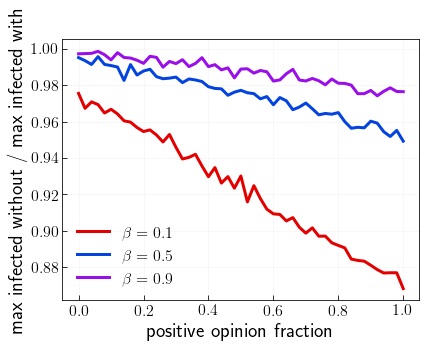

In [18]:
fun = lambda x: max_by_columns(x, 'infectedRate')
plt.plot(x, fun(on_beta_low) / fun(off_beta_low), color=colors[0], label=r'$\beta=0.1$')
plt.plot(x, fun(on_beta_middle) / fun(off_beta_middle), color=colors[1], label=r'$\beta=0.5$')
plt.plot(x, fun(on_beta_high) / fun(off_beta_high), color=colors[2], label=r'$\beta=0.9$')

# plt.plot(x, fun(on_beta_low_no) / fun(off_beta_low_no), color=colors[3], label=r'$\beta=0.1$ (V)')
# plt.plot(x, fun(on_beta_middle_no) / fun(off_beta_middle_no), color=colors[4], label=r'$\beta=0.5$ (V)')
# plt.plot(x, fun(on_beta_high_no) / fun(off_beta_high_no), color=colors[5], label=r'$\beta=0.9$ (V)')

plt.ylabel('max infected without / max infected with')
plt.legend()
plt.xlabel('positive opinion fraction')

### Ostateczna wartość osób wyzdrowiałych

W przypadku niskich wartości $\beta$ mamy mniej osób wyzdrowiałych. Natomiast to się łączy z tym, że w społeczeństwie pozostaje część osób, które wogóle nie zachorowały.

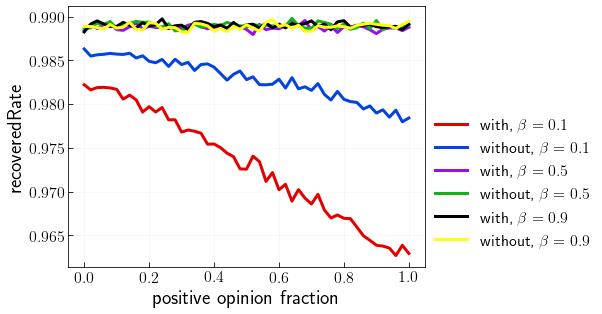

In [19]:
ys = [(on_beta_low, off_beta_low), (on_beta_middle, off_beta_middle), (on_beta_high, off_beta_high)]
betas = ['0.1', '0.5', '0.9']

plot_all_vals(ys, lambda x: last_by_columns(x, 'recoveredRate'), 'recoveredRate', betas)

### Pierwszy czas po którym w społeczeństwie będzie mniej niż 1% osób podatnych

Wartość zero na poniższym wykresie oznacza to, że nigdy nie dojdzie do sytuacji, że będzie mniej niż 1% osób podatnych. Czyli po prostu zostanie część osób podatnych.


Tylko dla niskich wartości $\beta$ do takiej sytuacji dojdzie. Widzimy tutaj znaczącą zaletę mechanizmu usuwania linków, ponieważ dla odsetku agentów mających opinię około 0.2 pozostanie część agentów w stanie $S$. Dla większych wartośći $\beta$ nie widać znaczych różnic.

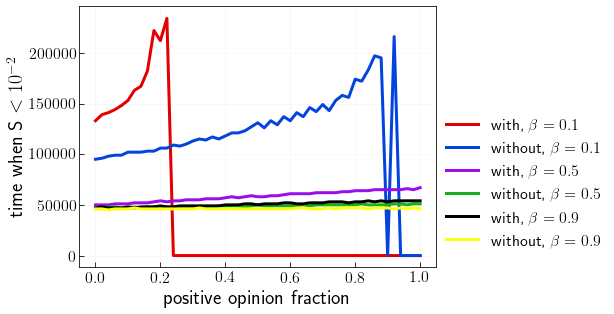

In [20]:
plot_all_vals(ys, time_to_no_susceptible, r'time when S $< 10^{-2}$', betas)